In [68]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

In [69]:
#/kaggle/input/emnist/emnist-letters-mapping.txt
testing_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-test.csv')
training_data = pd.read_csv('/kaggle/input/emnist/emnist-letters-train.csv')
print(training_data.shape)
print(testing_data.shape)

(88799, 785)
(14799, 785)


In [70]:
X_train = np.array(training_data.iloc[:,1:].values)
y_train = np.array(training_data.iloc[:,0].values)

X_test = np.array(testing_data.iloc[:,1:].values)
y_test = np.array(testing_data.iloc[:,0].values)

print(X_train.shape)
print(y_train.shape)

(88799, 784)
(88799,)


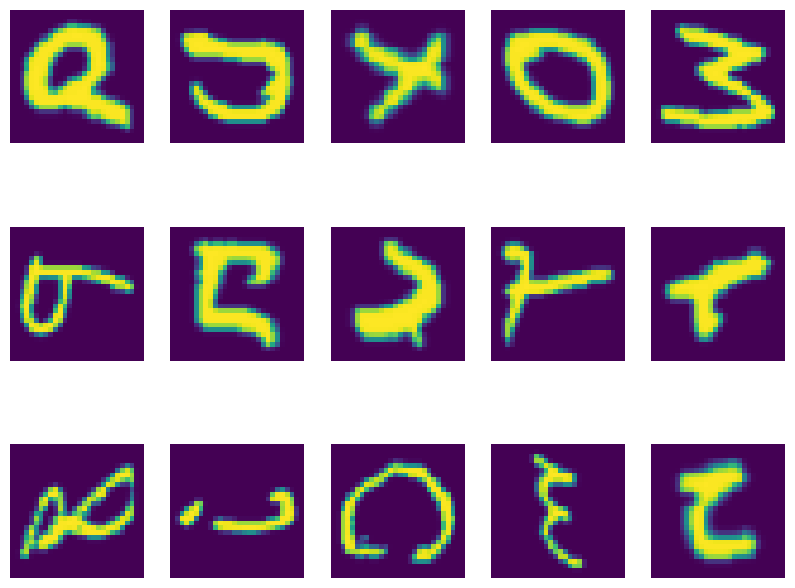

In [71]:
 from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=42) 

fig,axes = plt.subplots(3,5,figsize=(10,8))
for i,ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape([28,28]))
    ax.axis('off')

In [72]:
print(X_test.shape)
print(y_test.shape)

(14799, 784)
(14799,)


In [73]:
np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [74]:
np.unique(y_test)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

So as noticed, the testing labels don't have the 26 classes

In [75]:
print(len(y_train)+len(y_test))

103598


In [76]:
print(len(X_train) + len(X_test))

103598


In [77]:
X = np.concatenate((X_train, X_test), axis = 0)
y = np.concatenate((y_train, y_test), axis = 0)
print(y.shape)

(103598,)


Check if Data is imbalanced

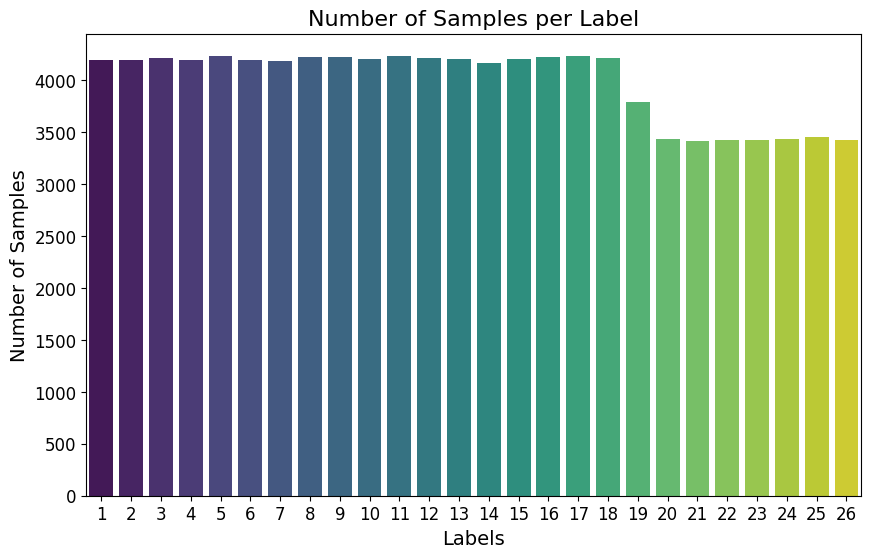

In [78]:
import seaborn as sns

# y is already a 1D array (no need for np.argmax)
label_counts = pd.Series(y).value_counts().sort_index()

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Number of Samples per Label', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Handling Imbalanced Data

In [79]:
from imblearn.under_sampling import RandomUnderSampler

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

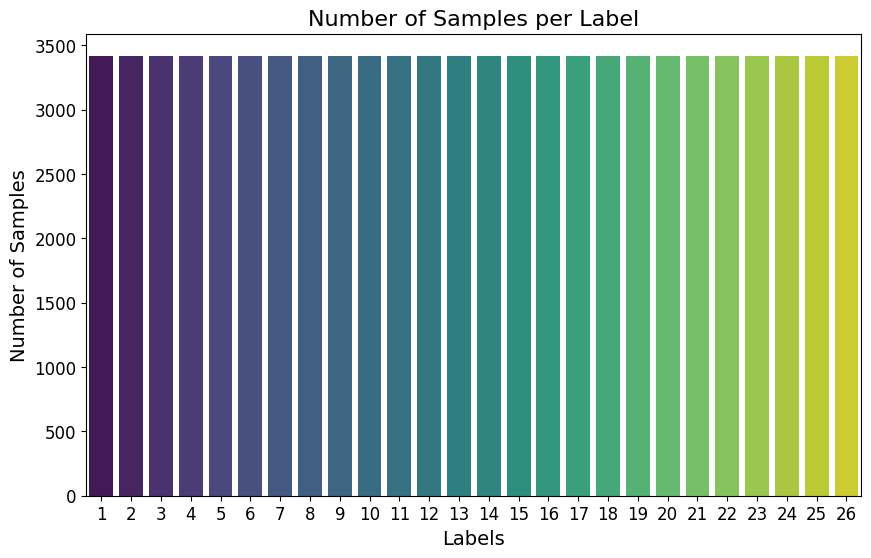

In [80]:
label_counts = pd.Series(y).value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Number of Samples per Label', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [81]:
X.shape

(88894, 784)

In [82]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [83]:
X_norm = X.astype('float32') / 255.0 

X_reshaped = X_norm.reshape(-1, 28, 28, 1)

X_rgb = np.repeat(X_reshaped, 3, axis=-1)

print("Images shape after RGB conversion:", X_rgb.shape)

Images shape after RGB conversion: (88894, 28, 28, 3)


In [84]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(y.reshape(-1, 1))

y_encoded = encoder.transform(y.reshape(-1, 1))

print("images shape:", X_rgb.shape)
print("labels shape:", y_encoded.shape)

images shape: (88894, 28, 28, 3)
labels shape: (88894, 26)


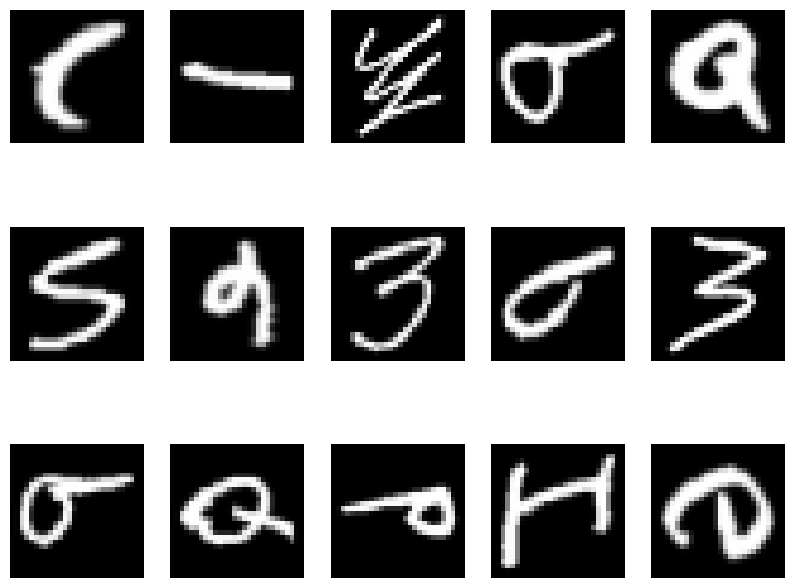

In [85]:
X_shuffled, y_shuffled = shuffle(X_rgb, y, random_state=42)

# Visualize the reshaped EMNIST images in RGB
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_shuffled[i])
    ax.axis('off')

Train Test Split

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X_rgb, y_encoded, test_size=0.2, random_state=42, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (71115, 28, 28, 3) (71115, 26)
Validation set: (8889, 28, 28, 3) (8889, 26)
Test set: (8890, 28, 28, 3) (8890, 26)


Data Augmentation

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
                                    rotation_range=90,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')


datagen.fit(X_train)
datagen.fit(X_val)
print('Done')

Done


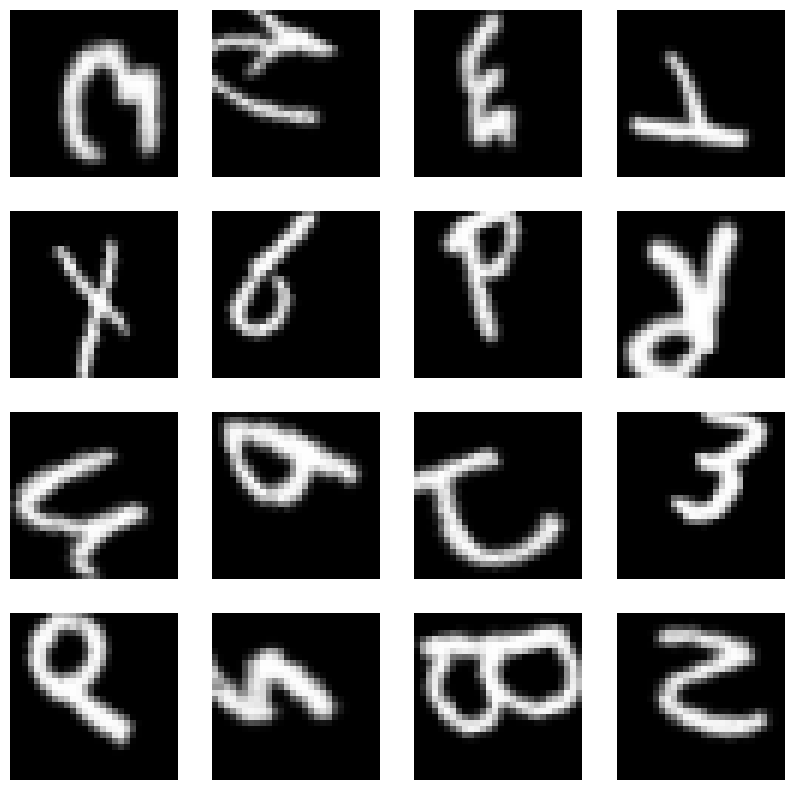

In [88]:
augmented_images = datagen.flow(X_train, batch_size=1, shuffle=True)

plt.figure(figsize=(10, 10))
for i in range(16):
    augmented_img = next(augmented_images)[0].astype('float32')
    plt.subplot(4, 4, i+1) 
    plt.imshow(augmented_img)
    plt.axis('off')
plt.show()

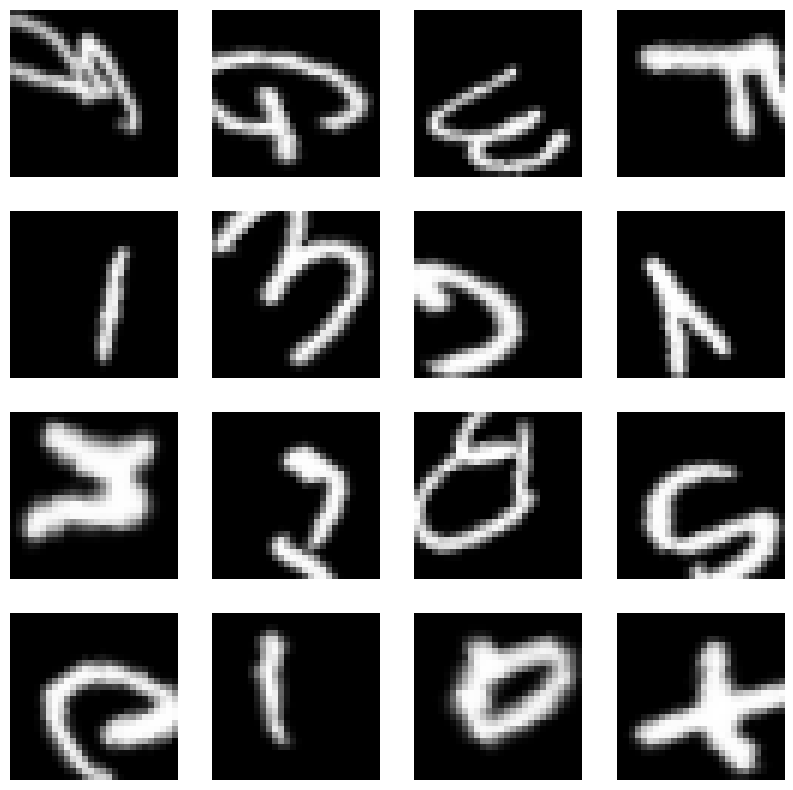

In [89]:
augmented_images = datagen.flow(X_val, batch_size=1, shuffle=True)

plt.figure(figsize=(10, 10))
for i in range(16):
    augmented_img = next(augmented_images)[0].astype('float32')
    plt.subplot(4, 4, i+1) 
    plt.imshow(augmented_img)
    plt.axis('off')
plt.show()

ResNet18 model (from-scratch)

In [90]:
from tensorflow.keras import layers, Input, Model, models

def residual_block(x, filters, stride=1, downsample=None, name=None, dropout_rate=0.2):
    identity = x  # Save input as identity for the skip connection

    # First convolution
    x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same', use_bias=False, name=f'{name}_conv1')(x)
    x = layers.BatchNormalization(name=f'{name}_bn1')(x)
    x = layers.ReLU(name=f'{name}_relu1')(x)
    x = layers.Dropout(dropout_rate, name=f'{name}_dropout1')(x)  # Apply dropout after ReLU

    # Second convolution
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False, name=f'{name}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name}_bn2')(x)
    x = layers.Dropout(dropout_rate, name=f'{name}_dropout2')(x)  # Apply dropout after BatchNorm

    # Adjust identity shape if necessary
    if stride != 1 or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, use_bias=False, name=f'{name}_downsample')(identity)
        identity = layers.BatchNormalization(name=f'{name}_downsample_bn')(identity)

    # Add skip connection
    x = layers.Add(name=f'{name}_add')([identity, x])
    x = layers.ReLU(name=f'{name}_relu2')(x)

    return x

In [91]:
def resnet18(input_tensor, num_classes=26, dropout_rate=0.2):
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=1, padding='same')(x)

    # Define the layers with residual blocks
    x = residual_block(x, 64, stride=1, name='block1', dropout_rate=dropout_rate)
    x = residual_block(x, 64, stride=1, name='block2', dropout_rate=dropout_rate)
    x = residual_block(x, 128, stride=2, name='block3', dropout_rate=dropout_rate)
    x = residual_block(x, 128, stride=1, name='block4', dropout_rate=dropout_rate)
    x = residual_block(x, 256, stride=2, name='block5', dropout_rate=dropout_rate)
    x = residual_block(x, 256, stride=1, name='block6', dropout_rate=dropout_rate)
    x = residual_block(x, 512, stride=2, name='block7', dropout_rate=dropout_rate)  
    x = residual_block(x, 512, stride=1, name='block8', dropout_rate=dropout_rate)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    return x

In [92]:
import tensorflow as tf
from tensorflow.keras import models

input_tensor = tf.keras.Input(shape=(28, 28, 3))

model_output = resnet18(input_tensor, num_classes=26, dropout_rate=0.2)

rn_model1 = models.Model(inputs=input_tensor, outputs=model_output)

rn_model1.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 28, 28, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      1,728 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 28, 28,    │     36,864 │ max_pooling2d_2[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_bn1          │ (None, 28, 28,    │        256 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_relu1 (ReLU) │ (None, 28, 28,    │          0 │ block1_bn1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_dropout1     │ (None, 28, 28,    │          0 │ block1_relu1[0][… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 28, 28,    │     36,864 │ block1_dropout1[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_bn2          │ (None, 28, 28,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_dropout2     │ (None, 28, 28,    │          0 │ block1_bn2[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_add (Add)    │ (None, 28, 28,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │ block1_dropout2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_relu2 (ReLU) │ (None, 28, 28,    │          0 │ block1_add[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 28, 28,    │     36,864 │ block1_relu2[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_bn1          │ (None, 28, 28,    │        256 │ block2_conv1[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_relu1 (ReLU) │ (None, 28, 28,    │          0 │ block2_bn1[0][0]

 Total params: 11,191,770 (42.69 MB)

 Trainable params: 11,182,170 (42.66 MB)

 Non-trainable params: 9,600 (37.50 KB)

First time epoching

In [93]:
# Convert one-hot encoded labels to integers
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)

rn_model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rn_history1 = rn_model1.fit(X_train, y_train_int, batch_size=32, epochs=3, validation_data=(X_val, y_val_int))

rn_model1.save('rn_model1.keras')

Epoch 1/3
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 143s 44ms/step - accuracy: 0.7651 - loss: 0.7579 - val_accuracy: 0.9002 - val_loss: 0.3158
Epoch 2/3
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - accuracy: 0.9147 - loss: 0.2517 - val_accuracy: 0.9245 - val_loss: 0.2363
Epoch 3/3
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - accuracy: 0.9269 - loss: 0.2081 - val_accuracy: 0.9253 - val_loss: 0.2334


In [94]:
rn_model1.evaluate(X_train,y_train_int)

2223/2223 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9293 - loss: 0.2022


[0.20771443843841553, 0.927736759185791]

Second time epoching

In [95]:
rn_model2 = load_model('/kaggle/working/rn_model1.keras')
rn_model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rn_history2 = rn_model2.fit(X_train, y_train_int, batch_size=32, epochs=3, validation_data=(X_val, y_val_int))
rn_model2.save('rn_model2.keras')

Epoch 1/3
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 143s 44ms/step - accuracy: 0.9318 - loss: 0.1936 - val_accuracy: 0.9355 - val_loss: 0.1908
Epoch 2/3
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - accuracy: 0.9441 - loss: 0.1594 - val_accuracy: 0.9259 - val_loss: 0.2492
Epoch 3/3
2223/2223 ━━━━━━━━━━━━━━━━━━━━ 63s 28ms/step - accuracy: 0.9484 - loss: 0.1427 - val_accuracy: 0.9417 - val_loss: 0.1741


In [96]:
rn_model2.evaluate(X_val, y_val_int)

278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9398 - loss: 0.1670


[0.1741277128458023, 0.9417257308959961]

In [97]:
y_pred = rn_model2.predict(X_test)

278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


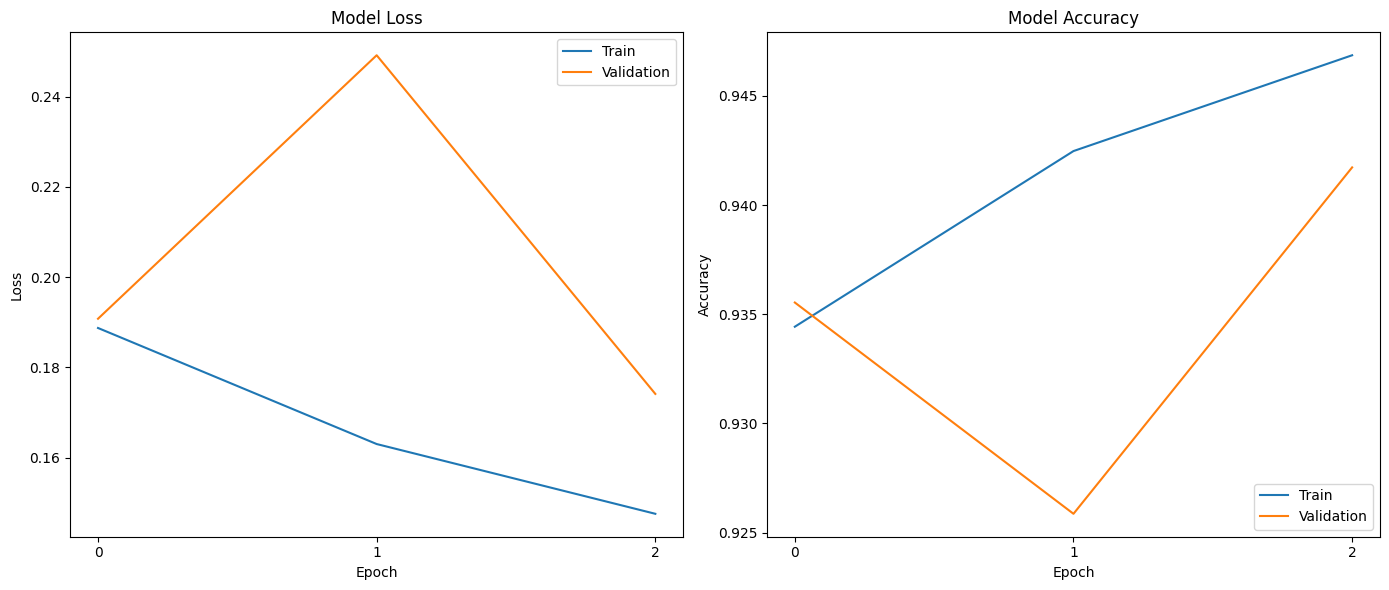

In [98]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot training & validation loss values
ax1.plot(rn_history2.history['loss'], label='Train')
ax1.plot(rn_history2.history['val_loss'], label='Validation')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

# Set x-ticks to integer values
ax1.set_xticks(range(len(rn_history2.history['loss'])))

# Plot training & validation accuracy values
ax2.plot(rn_history2.history['accuracy'], label='Train')
ax2.plot(rn_history2.history['val_accuracy'], label='Validation')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

# Set x-ticks to integer values
ax2.set_xticks(range(len(rn_history2.history['accuracy'])))

# Show the plots
plt.tight_layout()
plt.show()


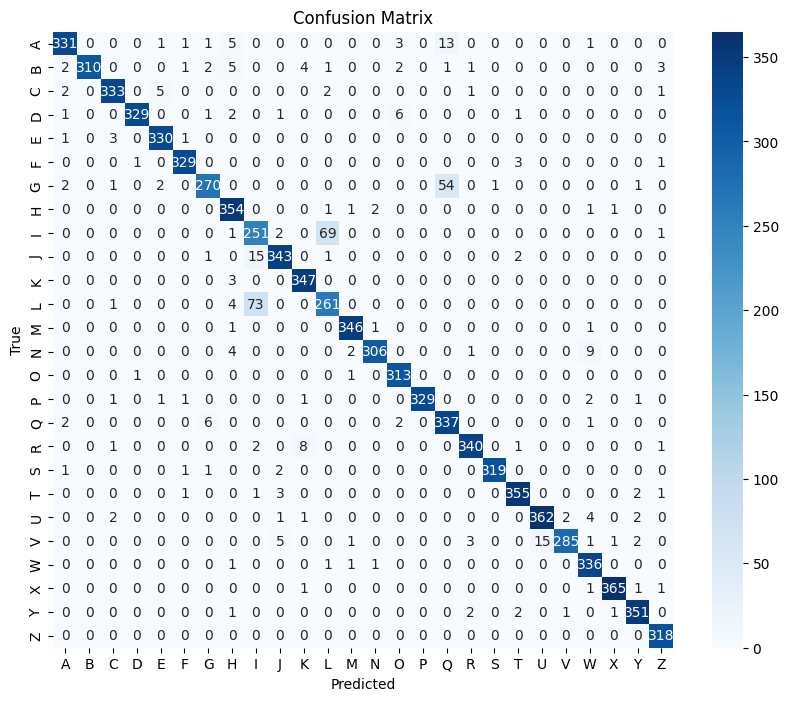

In [99]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_pred contains probabilities (one-hot or multi-class probabilities)
y_pred_labels = np.argmax(y_pred, axis=1)  # Get the class with the highest probability for each sample

# If y_test is one-hot encoded, convert it to labels too
y_test_labels = np.argmax(y_test, axis=1)

# Now, you can compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Create the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [100]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute Precision, Recall, and F-Score
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
fscore = f1_score(y_test_labels, y_pred_labels, average='weighted')

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {fscore:.4f}')

Precision: 0.9521
Recall: 0.9505
F1 Score: 0.9506


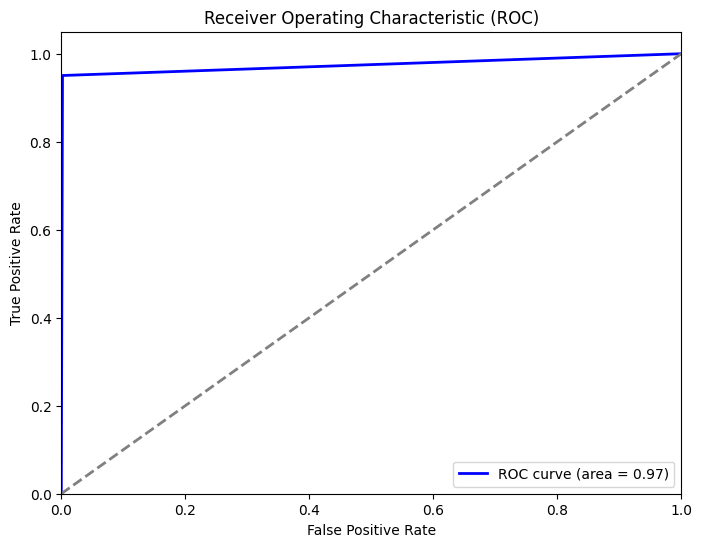

In [101]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test_labels)
y_pred_bin = lb.transform(y_pred_labels)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [102]:
print(f"AUC: {roc_auc:.4f}")

AUC: 0.9743


/tmp/ipykernel_23/3871344320.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(alphabets))  # Use tab20 color map for distinct colors


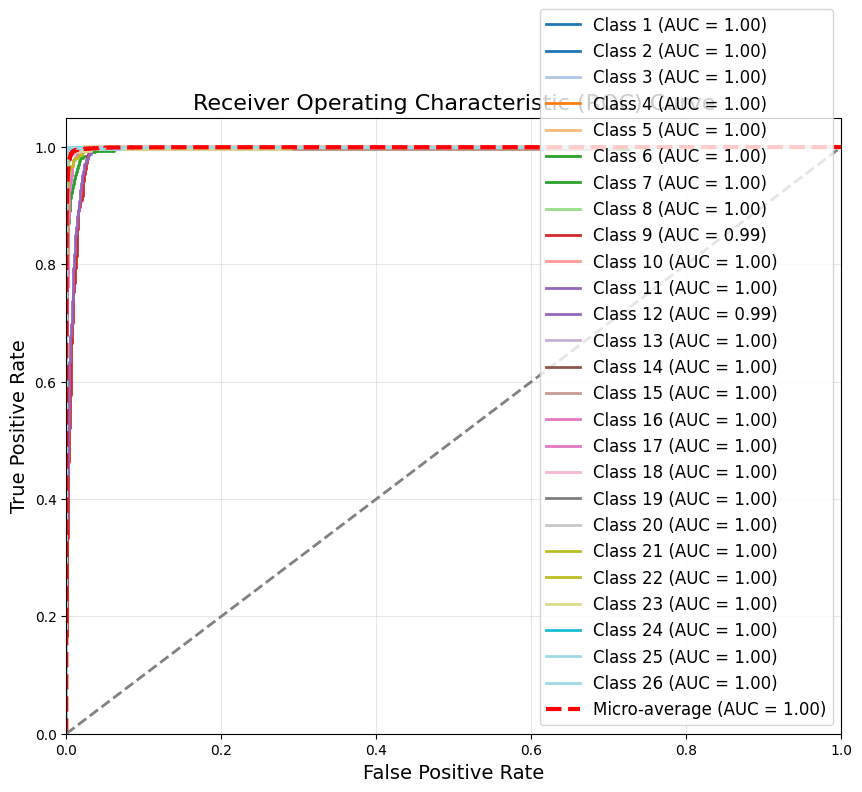

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import string

fpr = {}
tpr = {}
roc_auc = {}

alphabets = list(string.ascii_uppercase)

# Calculate ROC curve and AUC for each class
for i in range(len(alphabets)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab20', len(alphabets))  # Use tab20 color map for distinct colors

# Plot the ROC curve for each class
for i in range(len(alphabets)):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'Class {i+1} (AUC = {roc_auc[i]:0.2f})')

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], color='red', lw=3, linestyle='--', label=f'Micro-average (AUC = {roc_auc["micro"]:0.2f})')

# Plot the diagonal line (no-skill classifier)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)
plt.show()